# Predictive learning using kNN classifier (1)
## Dataset: ["Breast cancer"](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

## Analysis process flow
The picture attached below shows the steps followed for the resolution of the task. Q's represent in which step the questions asked in the task are answered.

![alt text](Analysis_workflow.png)

## STEP 1: Dataset exploration

In [1]:
# Imports for the task

from sklearn.datasets import load_breast_cancer

from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import pandas as pd

import numpy as np

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

> QUESTION 1: Using python examples developed in class, choose one of the following datasets and decribe what are its fields representing ("Digits", "Breast cancer").

In [2]:
# Load data
data = load_breast_cancer()

# Assign data and target to X, y variables to be used later on
X = data.data
y = data.target
targetNames = data.target_names

**"Breast cancer"** dataset includes **30 features per sample** concerning different **medical measurements on breasts attributes**. Each sample has a possible **binary label**: 0 for malignant and 1 for bening tumor. Features are **real positive numbers**, see the list of names below:

In [3]:
# Show first sample data using pandas
dataFrame = pd.DataFrame(X, columns=data.feature_names)
dataFrame.head(1)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


> QUESTION 2: Describe the dataset in number of samples, dimensions, classes and samples per class using python.

In [4]:
# Number of samples and dimensions
print("Number of samples, number of features:" + str(X.shape))

# Number of classes
print("Classes:" + str(targetNames))

# Number of samples per class
unique, counts = np.unique(y, return_counts = True)
print("Number of samples per class: " + str(dict(zip(unique, counts))))

Number of samples, number of features:(569L, 30L)
Classes:['malignant' 'benign']
Number of samples per class: {0: 212, 1: 357}


As a remark, number of samples per class within the dataset is not totally balanced (37% for malignant cases and 63% for benign).

** Visualization of the data using PCA**

We can visualize the data with the help of Principal Component Analysis (**PCA**) dimensionality reduction technique, which finds a linear combination of the variables that contains most of the information. These new variables are called “principal components”, which are the directions that maximize the variance of the data.

Let's represent "Breast cancer" data using **2 components**:

Variance retention using 2 components: 99.8221161374 %


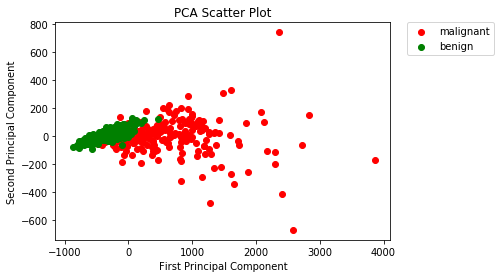

In [5]:
# Principal Component Analysis
myPCA = PCA(n_components = 2)
X_PCA = myPCA.fit_transform(X)

# Explained variance ratio
print ("Variance retention using 2 components: " + 
       str((np.sum(myPCA.fit(X).explained_variance_ratio_))*100) + " %")

# Plot PCA
colors = ['red', 'green']

for i in range(len(colors)):
    xPlot = X_PCA[:, 0][y == i]
    yPlot = X_PCA[:, 1][y == i]
    plt.scatter(xPlot, yPlot, c=colors[i])
    plt.legend(targetNames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

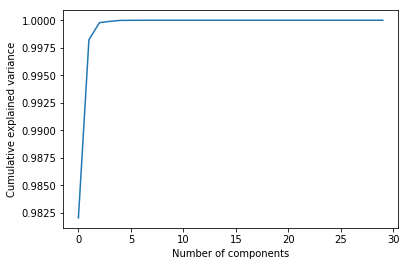

In [6]:
plt.plot(np.cumsum(PCA().fit(X).explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.show()

As we can see in the graph above, 2 components are enough for PCA representation as it is retaining **99,8 % of the variance of the data.**

> QUESTION 3: Repeat the examples performed in class.

The experiments performed in class are described in the **STEPS 2-7 of the analysis workflow showed below.**

## STEP 2: split data into Train, Test

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**. To avoid it, it is common practice when performing a supervised machine learning experiment to **hold out part of the available data as a test set XTest, yTest ** and be used only at the end of the data analysis. [[1]](http://scikit-learn.org/stable/modules/cross_validation.html)

For the splitting CV method ``` StratifiedShuffleSplit ``` (indicating 1 split) has been chosen for this task: it shuffles the dataset assuring the same proportion of samples per class in both Train and Test splits. The sizes chosen for Train-Test splits have been 70%-30% by chosing ```test_size = 0.3``` when calling the method. Additionally, by setting an integer for ```random_state``` attribute we are indicating a seed used by the random number generator for performing the splits with the aim of having the same split from now on in the exercise and compare the operations performed in the different sections in the same way.

In [7]:
## Split the data into Train, Test sets

myStratifiedShuffleSplit = StratifiedShuffleSplit(1, 0.3, random_state = 42)

for train_index, test_index in myStratifiedShuffleSplit.split(X, y):
    XTrain = X[train_index,:]
    XTest = X[test_index,:]
    yTrain = y[train_index]
    yTest = y[test_index]

# Sizes of each data split
print("Number of samples and dimensions for XTrain: " +str(XTrain.shape))
print("Number of labels for yTrain: " +str(yTrain.shape))
print("Number of samples and dimensions for XTest: " +str(XTest.shape))
print("Number of labels for yTest: " +str(yTest.shape))

Number of samples and dimensions for XTrain: (398L, 30L)
Number of labels for yTrain: (398L,)
Number of samples and dimensions for XTest: (171L, 30L)
Number of labels for yTest: (171L,)


## STEP 3: select a model

For this task model used is **k Nearest Neighbors (kNN)** which is a model used for **classification.** The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of neighbors (hyperparameter for kNN) can be a user-defined constant. [[2]](http://scikit-learn.org/stable/modules/neighbors.html#neighbors)

In [8]:
myModel = KNeighborsClassifier()

## STEP 4: obtain best estimator hyper-parameters using GridSearch cross-validation

When evaluating different hyperparameters for the estimator there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally, and consequently knowledge about the test set can “leak” into the model. To solve this problem, another part of the dataset can be held out as a so-called **validation set**: training proceeds on the training set, then evaluation is done on the validation set, and if it is successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, there are two problems: (1) Number of samples which can be used for learning the model is drastically reduced; and (2) the results can depend on a particular random choice for the pair of (train, validation) sets: here it comes **generalization error**, which is a measure of how accurately an algorithm is able to predict outcome values for previously unseen data. 

A solution to these problems is a procedure called **cross-validation (CV)**. A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. [[3]](http://scikit-learn.org/stable/modules/cross_validation.html). The 3 main methods for CV studied in class are **(Stratified)KFold**, **(Stratified)ShuffleSplit** and **LeaveOneOut**. In this first attempt we are using **KFold CV** method, in which the model is trained using k-1 of the folds as training data and
the resulting model is validated on the remaining part of the data.

The optimal hyperparameters for kNN classifier will be obtained using **GridSearch CV** method, which fits the model for every combination of hyper-parameters desired (several number of neighbors) and applies the desired CV over **XTrain, yTrain** sets that we obtained in STEP 2. 

In this first attempt,  ```weights```  parameter for kNN has been set as ```uniform``` , this mean that all points in each neighborhood are weighted equally.

In [9]:
#Function for running GridSearchCV

def runMyGridSearchCV(myModel, myParamGrid, myCV, XGrid, yGrid):
    
    myGridSearchCV = GridSearchCV(myModel, 
                              myParamGrid, 
                              cv = myCV,
                              verbose = 2, 
                              return_train_score = True)
    
    # Fit the grid
    myGridSearchCV.fit(XGrid, yGrid)
    
    # Display scores
    gridScores = pd.DataFrame(myGridSearchCV.cv_results_)
    display(gridScores)

    # BEST ESTIMATOR
    myBestModel = myGridSearchCV.best_estimator_
    print ("Best estimator: " + str(myBestModel))
    print ("Best grid cross-validation score: " + str(myGridSearchCV.best_score_))
            
    return myBestModel

In [10]:
# Run GridSearchCV with the desired CV
XGrid = XTrain
yGrid = yTrain
kVals = range(1, 30, 1)
myParamGrid = {'n_neighbors': kVals,
               'weights': ['uniform']}
myCV1 = KFold(n_splits = 10, random_state = 42)

# Run GridSearch CV for the given inputs
myBestModel1 = runMyGridSearchCV(myModel, myParamGrid, myCV1, XGrid, yGrid)

Fitting 10 folds for each of 29 candidates, totalling 290 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .

[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    9.7s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0037,0.0049,0.919598,1.000000,1,uniform,"{u'n_neighbors': 1, u'weights': u'uniform'}",28,0.925,1.000000,...,0.975,1.000000,0.871795,1.000000,0.974359,1.000000,0.001552,0.001921,0.038626,0.000000
1,0.0027,0.0046,0.937186,0.971246,2,uniform,"{u'n_neighbors': 2, u'weights': u'uniform'}",5,0.975,0.972067,...,0.975,0.972067,0.923077,0.969359,0.974359,0.969359,0.000781,0.001114,0.039183,0.002167
2,0.0031,0.0045,0.937186,0.954216,3,uniform,"{u'n_neighbors': 3, u'weights': u'uniform'}",5,0.950,0.955307,...,0.975,0.952514,0.948718,0.955432,1.000000,0.949861,0.000831,0.000806,0.037417,0.005744
3,0.0027,0.0039,0.942211,0.949749,4,uniform,"{u'n_neighbors': 4, u'weights': u'uniform'}",2,0.975,0.946927,...,0.975,0.944134,0.948718,0.952646,0.974359,0.944290,0.000640,0.000700,0.033590,0.004987
4,0.0029,0.0044,0.939698,0.950586,5,uniform,"{u'n_neighbors': 5, u'weights': u'uniform'}",3,0.975,0.949721,...,0.975,0.946927,0.897436,0.955432,1.000000,0.947075,0.000943,0.001200,0.035903,0.003760
5,0.0028,0.0038,0.947236,0.953099,6,uniform,"{u'n_neighbors': 6, u'weights': u'uniform'}",1,1.000,0.952514,...,0.975,0.952514,0.923077,0.955432,1.000000,0.949861,0.000600,0.000748,0.036241,0.004465
6,0.0029,0.0046,0.934673,0.947517,7,uniform,"{u'n_neighbors': 7, u'weights': u'uniform'}",10,0.975,0.938547,...,0.975,0.946927,0.897436,0.949861,1.000000,0.938719,0.000539,0.001625,0.037569,0.005394
7,0.0029,0.0038,0.937186,0.948354,8,uniform,"{u'n_neighbors': 8, u'weights': u'uniform'}",5,0.975,0.944134,...,0.975,0.944134,0.871795,0.949861,1.000000,0.944290,0.000700,0.000980,0.042553,0.003988
8,0.0031,0.0037,0.937186,0.942492,9,uniform,"{u'n_neighbors': 9, u'weights': u'uniform'}",5,0.975,0.938547,...,0.975,0.938547,0.897436,0.944290,1.000000,0.935933,0.001136,0.000781,0.039306,0.004851
9,0.0027,0.0037,0.939698,0.943887,10,uniform,"{u'n_neighbors': 10, u'weights': u'uniform'}",3,0.975,0.941341,...,0.975,0.938547,0.871795,0.944290,1.000000,0.938719,0.000640,0.001187,0.042497,0.004207


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')
Best grid cross-validation score: 0.947236180905


Result of GridSearch CV is that the optimal number of k for kNN is **6 neighbors**, which a **CV score of 94,72%**, **CV score standard deviation of 3,62%**, **train score of 95,31%** and **train score standard deviation of 0,45%**. 

Here we can perform a first evaluation of **underfitting** or **overfitting** by plotting **validation curve**. This is representing **Training / CV score vs Model complexity** (represented here by the number of neighbors -lower k higher complexity and viceversa-):

In [11]:
# Function for plotting VALIDATION CURVE

def plot_validation_curve(myEstimator, X, y, myParamRange, myCV, yLower, yUpper):
    train_scores, test_scores = validation_curve(
    myEstimator, X, y, param_name="n_neighbors", param_range=myParamRange,
    cv=myCV, scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with kNN")
    plt.xlabel("k")
    plt.ylabel("Score")
    plt.ylim(yLower, yUpper)
    lw = 2
    plt.semilogx(kVals, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(kVals, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(kVals, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(kVals, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

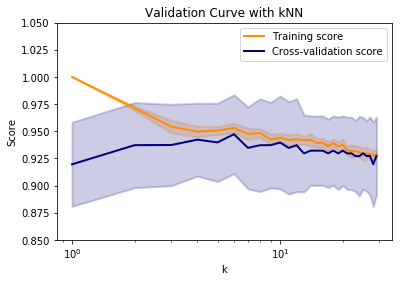

In [12]:
plot_validation_curve(myModel, XTrain, yTrain, kVals, myCV1, 0.85, 1.05)

Notes: Source code for plotting the curve from sklearn [[4]](http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html). This curve can be also represented plotting **Error vs Model complexity** (instead of score). 

In the graph above we can see that with the optimal 6 neighbors we are in an area with high training and test score, with both curves very near each other so it seems that there is no under or overfitting.

Maybe k=1 neighbors could generalize worst as is the minimum test score in the graph with the maximum train score, being the closest situation of overfitting in the model, but even though score there is very high **Underfitting** situation could probably happen with k >> 30, according to the tendency of the curve.

However, to demonstrate that our Best Model has no overfitting, after fitting (STEP 5) it is necessary to face the model to the unseen XTest (STEP 6) and different splits of the complete dataset (STEP 7).

But before let's check another options for model hyper-parameters and cross-validation methods (**Questions 4-7 from the task**), just in case we obtain a better score and a different optimal hyper-parameters configuration with them. In that case we will use it to  fit the model and continue with STEPS 4-7.

> QUESTION 4) Check the documentation for Scikit-learn library and configure the script for automatic validation (section 3) to allow that function GridSearchCV() uses Leave-one-out validation instead of K-fold. Describe which conclusions can be found from the mean scores of the cross validation and the test using a model with k neighbors with optimized k

This can be done by using  ```LeaveOneOut```  for  ```cv``` parameter within  ```GridSearchCV```. This method provides train/test indices to split data in train/test sets. Each sample is used once as a test set (singleton) while the remaining samples form the training set [[5]](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html). This method can be very time-consuming due to the high number of tests to be performed. 

In [13]:
myCV2 = LeaveOneOut()

# Run GridSearch CV for the given inputs
myBestModel2 = runMyGridSearchCV(myModel, myParamGrid, myCV2, XGrid, yGrid)

Fitting 398 folds for each of 29 candidates, totalling 11542 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ......

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] 

[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .

[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .

[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] .

[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ................... n_neighbors=3, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] ................... n_neighbors=4, weights=uniform, total=   0.0s
[CV] n_neighbors=4, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ................... n_neighbors=5, weights=uniform, total=   0.0s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] .

[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] .

[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=6, weights=uniform ..................................
[CV] ................... n_neighbors=6, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] .

[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] .

[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] ................... n_neighbors=7, weights=uniform, total=   0.0s
[CV] n_neighbors=7, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n

[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] ................... n_neighbors=9, weights=uniform, total=   0.0s
[CV] n_neighbors=9, weights=uniform ..................................
[CV] .

[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .

[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=10, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .

[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .................. n_neighbors=11, weights=uniform, total=   0.0s
[CV] n_neighbors=11, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .

[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .................. n_neighbors=12, weights=uniform, total=   0.0s
[CV] n_neighbors=12, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .

[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=13, weights=uniform, total=   0.0s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .................. n_neighbors=15, weights=uniform, total=   0.0s
[CV] n_neighbors=15, weights=uniform .................................
[CV] .

[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .................. n_neighbors=16, weights=uniform, total=   0.0s
[CV] n_neighbors=16, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .

[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .

[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .................. n_neighbors=17, weights=uniform, total=   0.0s
[CV] n_neighbors=17, weights=uniform .................................
[CV] .

[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .................. n_neighbors=18, weights=uniform, total=   0.0s
[CV] n_neighbors=18, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .

[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .

[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .................. n_neighbors=19, weights=uniform, total=   0.0s
[CV] n_neighbors=19, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .

[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .

[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .

[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n

[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .................. n_neighbors=21, weights=uniform, total=   0.0s
[CV] n_neighbors=21, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .................. n_neighbors=22, weights=uniform, total=   0.0s
[CV] n_neighbors=22, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .................. n_neighbors=23, weights=uniform, total=   0.0s
[CV] n_neighbors=23, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=24, weights=uniform .................................
[CV] .................. n_neighbors=24, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .................. n_neighbors=25, weights=uniform, total=   0.0s
[CV] n_neighbors=25, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .

[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .

[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .................. n_neighbors=27, weights=uniform, total=   0.0s
[CV] n_neighbors=27, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .................. n_neighbors=28, weights=uniform, total=   0.0s
[CV] n_neighbors=28, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .

[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .

[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .................. n_neighbors=29, weights=uniform, total=   0.0s
[CV] n_neighbors=29, weights=uniform .................................
[CV] .

[Parallel(n_jobs=1)]: Done 11542 out of 11542 | elapsed:  6.1min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split98_test_score,split98_train_score,split99_test_score,split99_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.003058,0.002558,0.919598,1.000000,1,uniform,"{u'n_neighbors': 1, u'weights': u'uniform'}",28,1.0,1.000000,...,1.0,1.000000,1.0,1.000000,1.0,1.000000,0.001398,0.001167,0.271915,0.000000
1,0.002995,0.002430,0.919598,0.972349,2,uniform,"{u'n_neighbors': 2, u'weights': u'uniform'}",28,1.0,0.972292,...,1.0,0.972292,1.0,0.972292,1.0,0.972292,0.000767,0.000879,0.271915,0.000576
2,0.002872,0.002372,0.932161,0.954768,3,uniform,"{u'n_neighbors': 3, u'weights': u'uniform'}",14,1.0,0.954660,...,1.0,0.954660,1.0,0.954660,1.0,0.954660,0.000651,0.000703,0.251470,0.000739
3,0.002894,0.002367,0.939698,0.949774,4,uniform,"{u'n_neighbors': 4, u'weights': u'uniform'}",2,1.0,0.949622,...,1.0,0.949622,1.0,0.949622,1.0,0.949622,0.000701,0.000654,0.238045,0.000742
4,0.002812,0.002374,0.942211,0.949787,5,uniform,"{u'n_neighbors': 5, u'weights': u'uniform'}",1,1.0,0.949622,...,1.0,0.949622,1.0,0.949622,1.0,0.949622,0.000644,0.000759,0.233344,0.000695
5,0.002899,0.002427,0.939698,0.954704,6,uniform,"{u'n_neighbors': 6, u'weights': u'uniform'}",2,1.0,0.954660,...,1.0,0.954660,1.0,0.954660,1.0,0.954660,0.000726,0.000725,0.238045,0.000678
6,0.002809,0.002354,0.939698,0.947230,7,uniform,"{u'n_neighbors': 7, u'weights': u'uniform'}",2,1.0,0.947103,...,1.0,0.947103,1.0,0.947103,1.0,0.947103,0.000664,0.000768,0.238045,0.000768
7,0.003055,0.002515,0.939698,0.949666,8,uniform,"{u'n_neighbors': 8, u'weights': u'uniform'}",2,1.0,0.949622,...,1.0,0.949622,1.0,0.949622,1.0,0.949622,0.000765,0.000820,0.238045,0.000724
8,0.002837,0.002432,0.939698,0.942249,9,uniform,"{u'n_neighbors': 9, u'weights': u'uniform'}",2,1.0,0.942065,...,1.0,0.942065,1.0,0.942065,1.0,0.942065,0.000720,0.000838,0.238045,0.000679
9,0.002852,0.002369,0.937186,0.944711,10,uniform,"{u'n_neighbors': 10, u'weights': u'uniform'}",7,1.0,0.944584,...,1.0,0.944584,1.0,0.944584,1.0,0.944584,0.000673,0.000965,0.242628,0.000747


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Best grid cross-validation score: 0.942211055276


Results obtained using ``LeaveOneOut`` are similar to ``KFold``: optimal k is 5 here and train / CV scores are similar to the ones obtained with ``KFold``. However, **CV score standard deviation is much higher here respect ``KFold``** (around 23,8% here), one possible explanation is that it is because the training sets in ``LeaveOneOut`` have more overlap and that makes the estimates from different folds more dependent than in  ``KFold``, and hence increases the overall variance [[6]](https://stats.stackexchange.com/questions/90902/why-is-leave-one-out-cross-validation-loocv-variance-about-the-mean-estimate-f/110537).

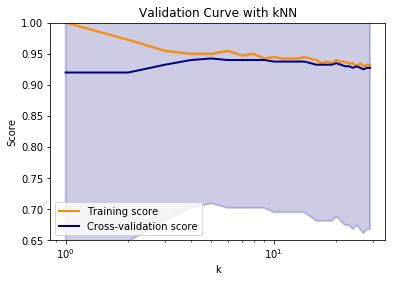

In [14]:
plot_validation_curve(myModel, XTrain, yTrain, kVals, myCV2, 0.65, 1)

Behavior of validation curve is similar here except for the already discussed CV score standard deviation.

> QUESTION 5) Think about if it is necessary to stratify CV process analyzing the distribution of samples per class.

Stratification makes sense specially with datasets where the number of samples per class is highly unbalanced, in order to preserve the relative class so that the model is capable or at least enough equipped to predict the outnumbered class (class with lesser points in number) [[7]](https://datascience.stackexchange.com/questions/16265/is-stratified-sampling-necessary-random-forest-python). In the case of this dataset, samples per class are not totaly balanced as showed in STEP 1 but neither in the extreme of highly unbalanced so the difference applying stratification should not be very high in this case:

In [15]:
myCV3 = StratifiedKFold(n_splits = 10, random_state = 42)

# Run GridSearch CV for the given inputs
myBestModel3 = runMyGridSearchCV(myModel, myParamGrid, myCV3, XGrid, yGrid)

Fitting 10 folds for each of 29 candidates, totalling 290 fits
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] ................... n_neighbors=1, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ................... n_neighbors=2, weights=uniform, total=   0.0s
[CV] n_neighbors=2, weights=uniform ..................................
[CV] .

[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] ................... n_neighbors=8, weights=uniform, total=   0.0s
[CV] n_neighbors=8, weights=uniform ..................................
[CV] .

[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .................. n_neighbors=14, weights=uniform, total=   0.0s
[CV] n_neighbors=14, weights=uniform .................................
[CV] .

[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n_neighbors=20, weights=uniform .................................
[CV] .................. n_neighbors=20, weights=uniform, total=   0.0s
[CV] n

[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .................. n_neighbors=26, weights=uniform, total=   0.0s
[CV] n_neighbors=26, weights=uniform .................................
[CV] .

[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    9.5s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0034,0.0045,0.924623,1.000000,1,uniform,"{u'n_neighbors': 1, u'weights': u'uniform'}",28,0.925,1.000000,...,0.975,1.000000,0.897436,1.000000,0.974359,1.000000,0.000663,0.002156,0.041926,0.000000
1,0.0029,0.0037,0.934673,0.970968,2,uniform,"{u'n_neighbors': 2, u'weights': u'uniform'}",8,0.950,0.969274,...,0.975,0.972067,0.948718,0.966574,0.948718,0.969359,0.000539,0.000781,0.039041,0.002829
2,0.0035,0.0041,0.937186,0.954496,3,uniform,"{u'n_neighbors': 3, u'weights': u'uniform'}",4,0.950,0.955307,...,0.975,0.949721,0.948718,0.955432,1.000000,0.949861,0.000922,0.000700,0.037417,0.005722
3,0.0031,0.0045,0.942211,0.949470,4,uniform,"{u'n_neighbors': 4, u'weights': u'uniform'}",1,0.950,0.949721,...,0.975,0.944134,0.948718,0.952646,0.974359,0.944290,0.000700,0.001204,0.029615,0.004573
4,0.0028,0.0038,0.937186,0.950586,5,uniform,"{u'n_neighbors': 5, u'weights': u'uniform'}",4,0.950,0.946927,...,0.975,0.946927,0.897436,0.955432,1.000000,0.947075,0.000400,0.000748,0.040873,0.004154
5,0.0031,0.0044,0.942211,0.953099,6,uniform,"{u'n_neighbors': 6, u'weights': u'uniform'}",1,0.950,0.952514,...,0.975,0.952514,0.923077,0.955432,1.000000,0.949861,0.000700,0.000800,0.038880,0.004465
6,0.0030,0.0043,0.932161,0.947517,7,uniform,"{u'n_neighbors': 7, u'weights': u'uniform'}",14,0.950,0.941341,...,0.975,0.946927,0.897436,0.949861,1.000000,0.938719,0.000000,0.000640,0.042046,0.005097
7,0.0031,0.0048,0.934673,0.947795,8,uniform,"{u'n_neighbors': 8, u'weights': u'uniform'}",8,0.950,0.941341,...,0.975,0.944134,0.871795,0.949861,1.000000,0.944290,0.000700,0.001887,0.046688,0.004999
8,0.0030,0.0035,0.934673,0.943050,9,uniform,"{u'n_neighbors': 9, u'weights': u'uniform'}",8,0.950,0.941341,...,0.975,0.938547,0.897436,0.944290,1.000000,0.935933,0.000775,0.000500,0.042289,0.005309
9,0.0025,0.0039,0.934673,0.944167,10,uniform,"{u'n_neighbors': 10, u'weights': u'uniform'}",8,0.950,0.941341,...,0.975,0.938547,0.871795,0.944290,1.000000,0.938719,0.000671,0.001136,0.045322,0.004819


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
Best grid cross-validation score: 0.942211055276


In this case it can be seen that applying stratification we obtain similar results as with KFold: best k is 4 neighbors here, and Train / CV scores and standard deviation are similar to ``KFold`` case.

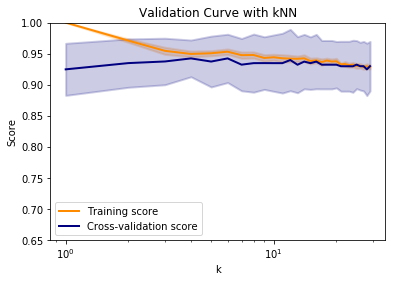

In [16]:
plot_validation_curve(myModel, XTrain, yTrain, kVals, myCV3, 0.65, 1)

**Sumary** after applying ``KFold``, ``LeaveOneOut`` and ``StratifiedKFold`` with ``uniform`` weights:

| CV method        | CV score      | CV std   | Train score  | Train std| Best k | Weights |
| ---------------- | -------------:| --------:|-------------:| --------:| ------:| -------:|
| KFold            | **<span style="color:green">0.9472</span>**        | 0.0372   | 0.9531       | 0.0045   |   6    | uniform |
| LeaveOneOut      | 0.9422        | **<span style="color:red">0.2333</span>**   | 0.9497       | 0.000695 |   5    | uniform |
| **StratifiedKFold**  | **0.9422**        | **<span style="color:green">0.029</span>**    | **0.9494**       | **0.004573** |   **4**    | **uniform** |

As the results were similar in the three CV options performed, we will continue with the stratification option for Questions 6-7 as standard deviation was the lowest and it stratification is generally more advisable.

> QUESTION 6) Introduce in CV process the adjustment of distance metric weights between samples according to the parameter `` weights `` of the model in scikit-learn. Calculate the gain / loss in model performance when distance metric weights are adjusted in CV respect the example seen in class (unique adjustment of k).

By chosing ``distance`` for ``weight`` parameter in kNN, the estimator weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. 

By default distance ``metric`` set in kNN is ``Euclidean`` (distance function is ``sqrt(sum((x - y)^2))``), as parameter for the Minkowski metric ``p`` is 2 by default. Let's run GridSearchCV using ``distance`` weights and compare the result with the previously obtained ``uniform``.

In [34]:
myParamGrid2 = {'n_neighbors': kVals,
               'weights': ['distance']}

# Run GridSearch CV for the given inputs
myBestModel4 = runMyGridSearchCV(myModel, myParamGrid2, myCV3, XGrid, yGrid)

Fitting 10 folds for each of 29 candidates, totalling 290 fits
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=1, weights=distance .................................
[CV] .................. n_neighbors=1, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] .................. n_neighbors=2, weights=distance, total=   0.0s
[CV] n_neighbors=2, weights=distance .................................
[CV] 

[CV] .................. n_neighbors=7, weights=distance, total=   0.0s
[CV] n_neighbors=7, weights=distance .................................
[CV] .................. n_neighbors=7, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .................. n_neighbors=8, weights=distance, total=   0.0s
[CV] n_neighbors=8, weights=distance .................................
[CV] .

[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] ................. n_neighbors=14, weights=distance, total=   0.0s
[CV] n_neighbors=14, weights=distance ................................
[CV] .

[CV] ................. n_neighbors=20, weights=distance, total=   0.0s
[CV] n_neighbors=20, weights=distance ................................
[CV] ................. n_neighbors=20, weights=distance, total=   0.0s
[CV] n_neighbors=20, weights=distance ................................
[CV] ................. n_neighbors=20, weights=distance, total=   0.0s
[CV] n_neighbors=20, weights=distance ................................
[CV] ................. n_neighbors=20, weights=distance, total=   0.0s
[CV] n_neighbors=20, weights=distance ................................
[CV] ................. n_neighbors=20, weights=distance, total=   0.0s
[CV] n_neighbors=20, weights=distance ................................
[CV] ................. n_neighbors=20, weights=distance, total=   0.0s
[CV] n_neighbors=20, weights=distance ................................
[CV] ................. n_neighbors=20, weights=distance, total=   0.0s
[CV] n_neighbors=20, weights=distance ................................
[CV] .

[CV] ................. n_neighbors=26, weights=distance, total=   0.0s
[CV] n_neighbors=26, weights=distance ................................
[CV] ................. n_neighbors=26, weights=distance, total=   0.0s
[CV] n_neighbors=26, weights=distance ................................
[CV] ................. n_neighbors=26, weights=distance, total=   0.0s
[CV] n_neighbors=26, weights=distance ................................
[CV] ................. n_neighbors=26, weights=distance, total=   0.0s
[CV] n_neighbors=26, weights=distance ................................
[CV] ................. n_neighbors=26, weights=distance, total=   0.0s
[CV] n_neighbors=26, weights=distance ................................
[CV] ................. n_neighbors=26, weights=distance, total=   0.0s
[CV] n_neighbors=26, weights=distance ................................
[CV] ................. n_neighbors=26, weights=distance, total=   0.0s
[CV] n_neighbors=27, weights=distance ................................
[CV] .

[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    9.4s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0026,0.0041,0.924623,1.0,1,distance,"{u'n_neighbors': 1, u'weights': u'distance'}",28,0.925,1.0,...,0.975,1.0,0.897436,1.0,0.974359,1.0,0.000490,9.434182e-04,0.041926,0.0
1,0.0025,0.0032,0.924623,1.0,2,distance,"{u'n_neighbors': 2, u'weights': u'distance'}",28,0.925,1.0,...,0.975,1.0,0.897436,1.0,0.974359,1.0,0.000500,3.999949e-04,0.041926,0.0
2,0.0024,0.0032,0.934673,1.0,3,distance,"{u'n_neighbors': 3, u'weights': u'distance'}",13,0.950,1.0,...,0.975,1.0,0.948718,1.0,1.000000,1.0,0.000490,3.999829e-04,0.035588,0.0
3,0.0030,0.0040,0.942211,1.0,4,distance,"{u'n_neighbors': 4, u'weights': u'distance'}",1,0.950,1.0,...,0.975,1.0,0.923077,1.0,1.000000,1.0,0.000633,9.999990e-04,0.033686,0.0
4,0.0053,0.0037,0.937186,1.0,5,distance,"{u'n_neighbors': 5, u'weights': u'distance'}",6,0.950,1.0,...,0.975,1.0,0.897436,1.0,1.000000,1.0,0.007925,7.810477e-04,0.040873,0.0
5,0.0034,0.0040,0.942211,1.0,6,distance,"{u'n_neighbors': 6, u'weights': u'distance'}",1,0.950,1.0,...,0.975,1.0,0.923077,1.0,1.000000,1.0,0.000663,1.000071e-03,0.038880,0.0
6,0.0031,0.0043,0.934673,1.0,7,distance,"{u'n_neighbors': 7, u'weights': u'distance'}",13,0.950,1.0,...,0.975,1.0,0.897436,1.0,1.000000,1.0,0.000831,1.005014e-03,0.040777,0.0
7,0.0029,0.0040,0.932161,1.0,8,distance,"{u'n_neighbors': 8, u'weights': u'distance'}",19,0.950,1.0,...,0.975,1.0,0.897436,1.0,1.000000,1.0,0.000538,1.183191e-03,0.043514,0.0
8,0.0034,0.0044,0.932161,1.0,9,distance,"{u'n_neighbors': 9, u'weights': u'distance'}",19,0.950,1.0,...,0.975,1.0,0.897436,1.0,1.000000,1.0,0.000800,9.164903e-04,0.042046,0.0
9,0.0042,0.0118,0.934673,1.0,10,distance,"{u'n_neighbors': 10, u'weights': u'distance'}",13,0.950,1.0,...,0.975,1.0,0.897436,1.0,1.000000,1.0,0.000872,1.208963e-02,0.042289,0.0


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')
Best grid cross-validation score: 0.942211055276


Introducing distance weights, we **improve training accuracy up to 100% without jeopardizing the generalization ability of the algorithm**, as we can see in the **comparison between uniform and distance**:

| CV method | CV score | CV std | Train score  | Train std| Best k | Weights | Metric |
| --------- | --------:| ------:|-------------:| --------:| ------:| -------:|-------:|
| StratifiedKFold  | 0.9422        | 0.029    | 0.9494       |0.004573 |   4    | uniform |        |
| StratifiedKFold     | 0.9422   | 0.0336      | 1       | 0 |   4    | distance | Euclidean |

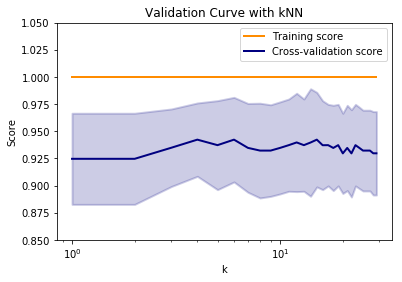

In [17]:
myModel2 = KNeighborsClassifier(weights="distance")
plot_validation_curve(myModel2, XTrain, yTrain, kVals, myCV3, 0.85, 1.05)

According to the validation curve, with optimal k there is no appearance of under-overfitting, as both training and CV scores are high with similar tendency.

> QUESTION 7) Following the same approach as in the previous question, introduce the type of distance ``metric`` in CV process. Evaluate the results and gain / losses of generalization capacity of the model.

Below several other distance metrics feasible for this dataset (real-valued vector space) are tested: 
- **manhattan** (distance function:  ``sum(|x - y|)``) 
- **chebyshev** (distance function:  ``max(|x - y|)``):

In [36]:
myParamGrid3 = {'n_neighbors': kVals,
               'weights': ['distance'],
               'metric':['manhattan', 'chebyshev']}

# Run GridSearch CV for the given inputs
myBestModel5 = runMyGridSearchCV(myModel, myParamGrid3, myCV3, XGrid, yGrid)

Fitting 10 folds for each of 58 candidates, totalling 580 fits
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighb

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=1, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=1, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=2, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=2, metric=manhattan, weights=distance ...............
[CV] 

[CV] n_neighbors=8, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=8, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=8, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=8, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=8, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=8, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=8, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=8, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=8, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=8, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=8, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=8, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=9, metric=manhattan, weights=distance ...............
[CV]  n_neighbors=9, metric=manhattan, weights=distance, total=   0.0s
[CV] n

[CV]  n_neighbors=14, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=14, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=14, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=14, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=14, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=14, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=14, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=14, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=14, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=14, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=14, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=14, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=14, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=15, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=20, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=20, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=20, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=20, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=20, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=21, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=21, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=21, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=21, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=21, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=21, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=21, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=21, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=21, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=27, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=27, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=27, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=27, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=27, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=27, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=27, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=27, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=27, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=27, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=27, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=27, metric=manhattan, weights=distance ..............
[CV]  n_neighbors=27, metric=manhattan, weights=distance, total=   0.0s
[CV] n_neighbors=27, metric=manhattan, weights=distance ..............

[CV]  n_neighbors=4, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=4, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=4, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=4, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=4, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=4, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=4, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=4, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=4, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=4, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=4, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=4, metric=chebyshev, weights=distance ...............
[CV]  n_neighbors=4, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=4, metric=chebyshev, weights=distance ...............
[CV]  

[CV]  n_neighbors=10, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=10, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=10, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=10, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=10, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=10, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=10, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=10, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=10, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=10, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=10, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=11, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=11, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=11, metric=chebyshev, weights=distance ..............

[CV]  n_neighbors=16, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=16, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=16, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=16, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=16, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=16, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=16, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=16, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=16, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=16, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=16, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=16, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=16, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=16, metric=chebyshev, weights=distance ..............

[CV] n_neighbors=22, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=22, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=22, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=22, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=22, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=22, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=22, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=22, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=22, metric=chebyshev, weights=distance, total=   0.0s

[CV]  n_neighbors=28, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=28, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=28, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=28, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=28, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=28, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=28, metric=chebyshev, weights=distance ..............
[CV]  n_neighbors=28, metric=chebyshev, weights=distance, total=   0.0s
[CV] n_neighbors=29, metric=chebyshev, weights=distance ..............

[Parallel(n_jobs=1)]: Done 580 out of 580 | elapsed:   15.0s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_metric,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0029,0.0036,0.927136,1.0,manhattan,1,distance,"{u'n_neighbors': 1, u'metric': u'manhattan', u...",51,0.925,...,0.975,1.0,0.923077,1.0,0.948718,1.0,8.306338e-04,7.999539e-04,0.034374,0.0
1,0.0025,0.0029,0.927136,1.0,manhattan,2,distance,"{u'n_neighbors': 2, u'metric': u'manhattan', u...",51,0.925,...,0.975,1.0,0.923077,1.0,0.948718,1.0,8.062561e-04,3.000498e-04,0.034374,0.0
2,0.0022,0.0034,0.937186,1.0,manhattan,3,distance,"{u'n_neighbors': 3, u'metric': u'manhattan', u...",12,0.950,...,0.975,1.0,0.948718,1.0,1.000000,1.0,4.000187e-04,6.632985e-04,0.033894,0.0
3,0.0021,0.0031,0.942211,1.0,manhattan,4,distance,"{u'n_neighbors': 4, u'metric': u'manhattan', u...",6,0.950,...,0.975,1.0,0.948718,1.0,1.000000,1.0,3.000021e-04,5.385306e-04,0.033566,0.0
4,0.0024,0.0036,0.942211,1.0,manhattan,5,distance,"{u'n_neighbors': 5, u'metric': u'manhattan', u...",6,0.950,...,0.975,1.0,0.948718,1.0,1.000000,1.0,4.898722e-04,6.633272e-04,0.038776,0.0
5,0.0023,0.0031,0.944724,1.0,manhattan,6,distance,"{u'n_neighbors': 6, u'metric': u'manhattan', u...",3,0.950,...,0.975,1.0,0.948718,1.0,1.000000,1.0,4.582712e-04,2.999783e-04,0.041531,0.0
6,0.0022,0.0029,0.942211,1.0,manhattan,7,distance,"{u'n_neighbors': 7, u'metric': u'manhattan', u...",6,0.950,...,0.975,1.0,0.948718,1.0,1.000000,1.0,4.000306e-04,3.000498e-04,0.043364,0.0
7,0.0023,0.0032,0.942211,1.0,manhattan,8,distance,"{u'n_neighbors': 8, u'metric': u'manhattan', u...",6,0.950,...,0.975,1.0,0.948718,1.0,1.000000,1.0,4.582816e-04,4.000783e-04,0.043364,0.0
8,0.0024,0.0033,0.942211,1.0,manhattan,9,distance,"{u'n_neighbors': 9, u'metric': u'manhattan', u...",6,0.950,...,0.975,1.0,0.948718,1.0,1.000000,1.0,4.898624e-04,7.810203e-04,0.041891,0.0
9,0.0022,0.0030,0.949749,1.0,manhattan,10,distance,"{u'n_neighbors': 10, u'metric': u'manhattan', ...",1,0.950,...,0.975,1.0,0.948718,1.0,1.000000,1.0,4.000187e-04,7.152557e-08,0.041864,0.0


Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')
Best grid cross-validation score: 0.949748743719


CV score obtained using ``manhattan`` distance metric was the **highest among all the CV performed until now (94,47%)** and standard deviation is similar, so in this time we also improved the generalization ability of the model. Consequently, we will follow the rest of pending STEPS 5-7 with this Best Model with **{k=10, weights distance, metric 'manhattan'}**.

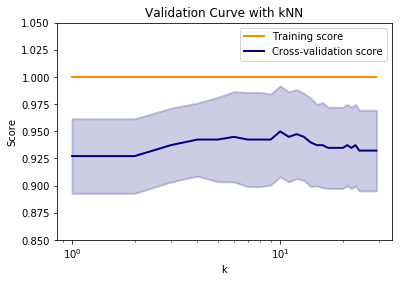

In [37]:
myModel3 = KNeighborsClassifier(weights="distance", metric="manhattan")
plot_validation_curve(myModel3, XTrain, yTrain, kVals, myCV3, 0.85, 1.05)

Validation curve here is similar to euclidean but with CV score for optimal k=10 (and consequently generalization capacity of the model) increased for the same 100% training score.

## STEP 5: Fit the Best Model with XTrain, YTrain

In [38]:
# Fit model with Best estimator from step 3

myBestModel = myBestModel5
myBestModel.fit(XTrain, yTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')

## STEP 6: Evaluate the score on XTest prediction

In [39]:
# Predict XTest using Best Estimator

yPred = myBestModel.predict(XTest)
yTrue = yTest

Below several metrics for quantifying the quality of the prediction are checked. The metrics below are some of the suitable metrics for binary targets, as it this is the case.

***- Accuracy score***

In [40]:
## Accuracy score
print("Accuracy score: " + str(accuracy_score(yTrue, yPred)))

Accuracy score: 0.941520467836


According to accuracy score (94,15 %) similar to the validation score, the best model predicts well when applied to unseen data.

***- Classification report***

It shows the following scores for each class:

- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)
- f1-score = (2 · Precision · Recall) / (Precision + Recall)

Where TP=True Positives; FP=False positives; FN=False negatives

In [41]:
# Classification report
print("CLASSIFICATION REPORT USING THE BEST ESTIMATOR:")
print(classification_report(yTrue, yPred))

CLASSIFICATION REPORT USING THE BEST ESTIMATOR:
             precision    recall  f1-score   support

          0       0.95      0.89      0.92        64
          1       0.94      0.97      0.95       107

avg / total       0.94      0.94      0.94       171



Conclusions:
- **Precision** for both classes is balanced 
- **Recall** for "malignant" class is the lowest. It means that predictions for "malignant" class takes some noise from "benign" class, predicting an 11% of true XTest malignant samples as benign. This mean that class "malignant" has more misclassification errors than "benign".

Confusion matrix below shows recall information in more detail:

***- Confusion matrix***

In [42]:
# Function to plot confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

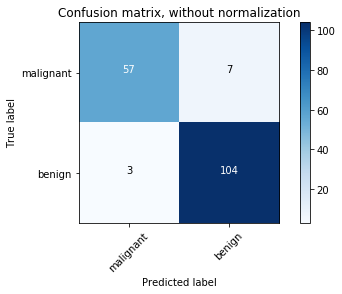

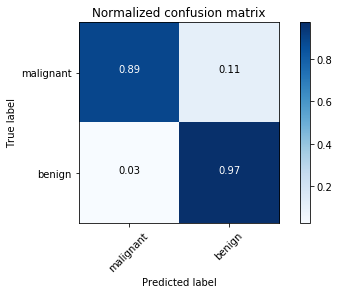

In [43]:
# Compute confusion matrix
confMatrix = confusion_matrix(yTrue, yPred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMatrix, classes=targetNames, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confMatrix, classes=targetNames, normalize=True, title='Normalized confusion matrix')

Confusion matrix provides a deeper knowledge about the previously discussed recall. Non-normalized graph shows support (number of samples in XTest) for TP, FP and FN and normalized shows it in percentages. Here the conclusion is the same, prediction for "malignant" cases is worse than for "benign" (misclassification error is higher in "malignant").

## STEP 7: Cross-validation with the complete dataset

Now that the estimator performed well in cross-validation and with unseen data (XTest), now it is time to check that taking the complete dataset and showing the estimator brand-new splits, it still can be fit and predict accurately, and with low standard deviation between the splits. For that purpose, we can use ** ``cross_val_score`` ** function, with the inputs of the Best Estimator, (X,y) and CV strategy:

In [44]:
# Cross-validation of the Best Estimator with the entire dataset
myStratifiedShuffleSplit = StratifiedShuffleSplit(100, 0.3, random_state = 42)
myCrosValScore = cross_val_score(myBestModel, X, y, cv=myStratifiedShuffleSplit)

print(myCrosValScore)
print ("Mean accuracy score: " + str(np.mean(myCrosValScore)))
print ("Std deviation: " + str(np.std(myCrosValScore)))

[ 0.94  0.94  0.92  0.92  0.95  0.94  0.94  0.92  0.95  0.95  0.95  0.95
  0.96  0.91  0.92  0.95  0.96  0.95  0.95  0.94  0.94  0.93  0.93  0.93
  0.92  0.92  0.95  0.94  0.92  0.94  0.93  0.93  0.95  0.95  0.94  0.92
  0.98  0.93  0.91  0.94  0.92  0.94  0.94  0.92  0.94  0.95  0.94  0.98
  0.93  0.94  0.98  0.94  0.93  0.95  0.92  0.94  0.94  0.94  0.94  0.94
  0.88  0.95  0.91  0.94  0.94  0.96  0.91  0.95  0.9   0.97  0.95  0.97
  0.95  0.96  0.94  0.95  0.94  0.92  0.94  0.93  0.96  0.95  0.96  0.94
  0.94  0.9   0.95  0.94  0.93  0.94  0.92  0.93  0.93  0.91  0.96  0.94
  0.96  0.93  0.91  0.96]
Mean accuracy score: 0.938245614035
Std deviation: 0.0174327867919


As showed, **estimator is still robust when facing 100 new splits of the dataset**, with an **mean score of 93,84 %** and a **low standard deviation between splits (1,74 %)**.

**Summary of the results**:

| (XTrain,yTrain)<br> CV score | (XTrain,yTrain)<br> CV std | (XTrain,yTrain)<br> Train score | (XTrain,yTrain) <br>Train std | Best k | Weights | metric | (XTest)<br> acc_score | (X,y)<br> mean_acc_score  | (X,y)<br> std_acc_score |
| -------- | --------:|-------------:| --------:| ------:| -------:| ---------:|---------:|---------:|
| 0.9497   |      0.0447    |      1        | 0        |   10     | distance| manhattan | 0.9415  |0.9382 | 0.0174|

***- Decision boundaries***

We can plot the decision regions of the estimator to learn visually how it performs the classification:

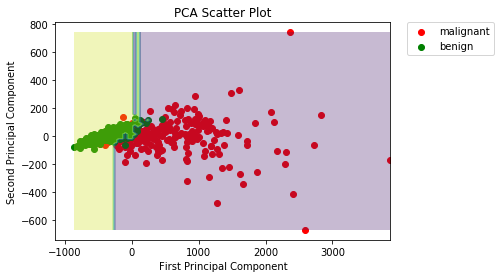

In [45]:
# Plot decision regions

myPCA = PCA(n_components = 2)
X_PCA = myPCA.fit_transform(X)
colors = ['red', 'green']

for i in range(len(colors)):
    xPlotPCA = X_PCA[:, 0][y == i]
    yPlotPCA = X_PCA[:, 1][y == i]
    plt.scatter(xPlotPCA, yPlotPCA, c=colors[i])
    plt.legend(targetNames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
#plt.show()

myBestModel.fit(X_PCA, y)

xx1, xx2 = np.meshgrid(np.linspace(X_PCA[:,0].min(),X_PCA[:,0].max(),100),np.linspace(X_PCA[:,1].min(),X_PCA[:,1].max(),100))

Z = myBestModel.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

plt.contourf(xx1, xx2, Z, alpha=0.3)
plt.axis('tight')
plt.show()

Here we can see what we observed in classification report and confusion matrix, decision region for malignant takes more noise from bening samples (even if misclassification percentage is not high, see region in the middle of both clasess) than viceversa (in decision region for benign we can see that recall is almost perfect, almost everything predited as bening is in fact benign).

***- Validation and Learning curves***

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

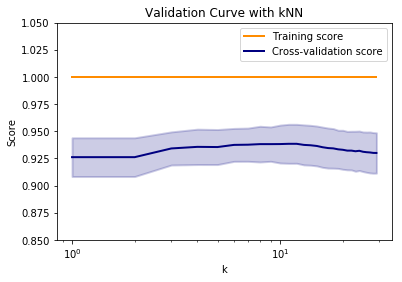

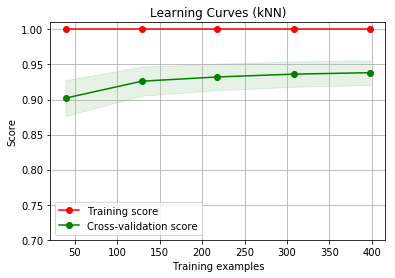

In [47]:
# Plot validation curve
myModel3 = KNeighborsClassifier(weights="distance", metric="manhattan")
plot_validation_curve(myModel3, X, y, kVals, myStratifiedShuffleSplit, 0.85, 1.05)

# Plot learning curve
plot_learning_curve(myBestModel, "Learning Curves (kNN)", X, y, ylim=(0.7, 1.01), cv=myStratifiedShuffleSplit, n_jobs=4)
plt.show()

Both Validation and Learning curves are useful tools for under and overfitting evaluation.

Representing them for the entire dataset and the given final CV, we get the following conclusions:
- **Validation curve**: Selecting {k=10, manhattan distance} for our model does not seem to mean that we are in an under or overfitting situation, as there is **high score / low bias (error) in both training and CV**.
- **Learning curve**: reasoning is similar as in validation curve, there is **high score / low bias for both training and CV** and, even a gap between them exists, **gap between training and CV is small, which means a low variance**.